In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
import os
import warnings

In [2]:
activities="""1 WALKING,2 WALKING_UPSTAIRS,3 WALKING_DOWNSTAIRS,4 SITTING,5 STANDING,6 LAYING"""
activities={int(a[0]): a[1].replace("_", " ").title() for a in [i.split(" ") for i in activities.split(",")]}

In [3]:
y_test=pd.read_csv("data/2012/test/y_test.txt", sep=" ", header=None)
y_test.columns=["Activity"]
y_train=pd.read_csv("data/2012/train/y_train.txt", sep=" ", header=None)
y_train.columns=["Activity"]
y=pd.concat([y_test, y_train])
y["Activity"]=y.Activity.map(activities)

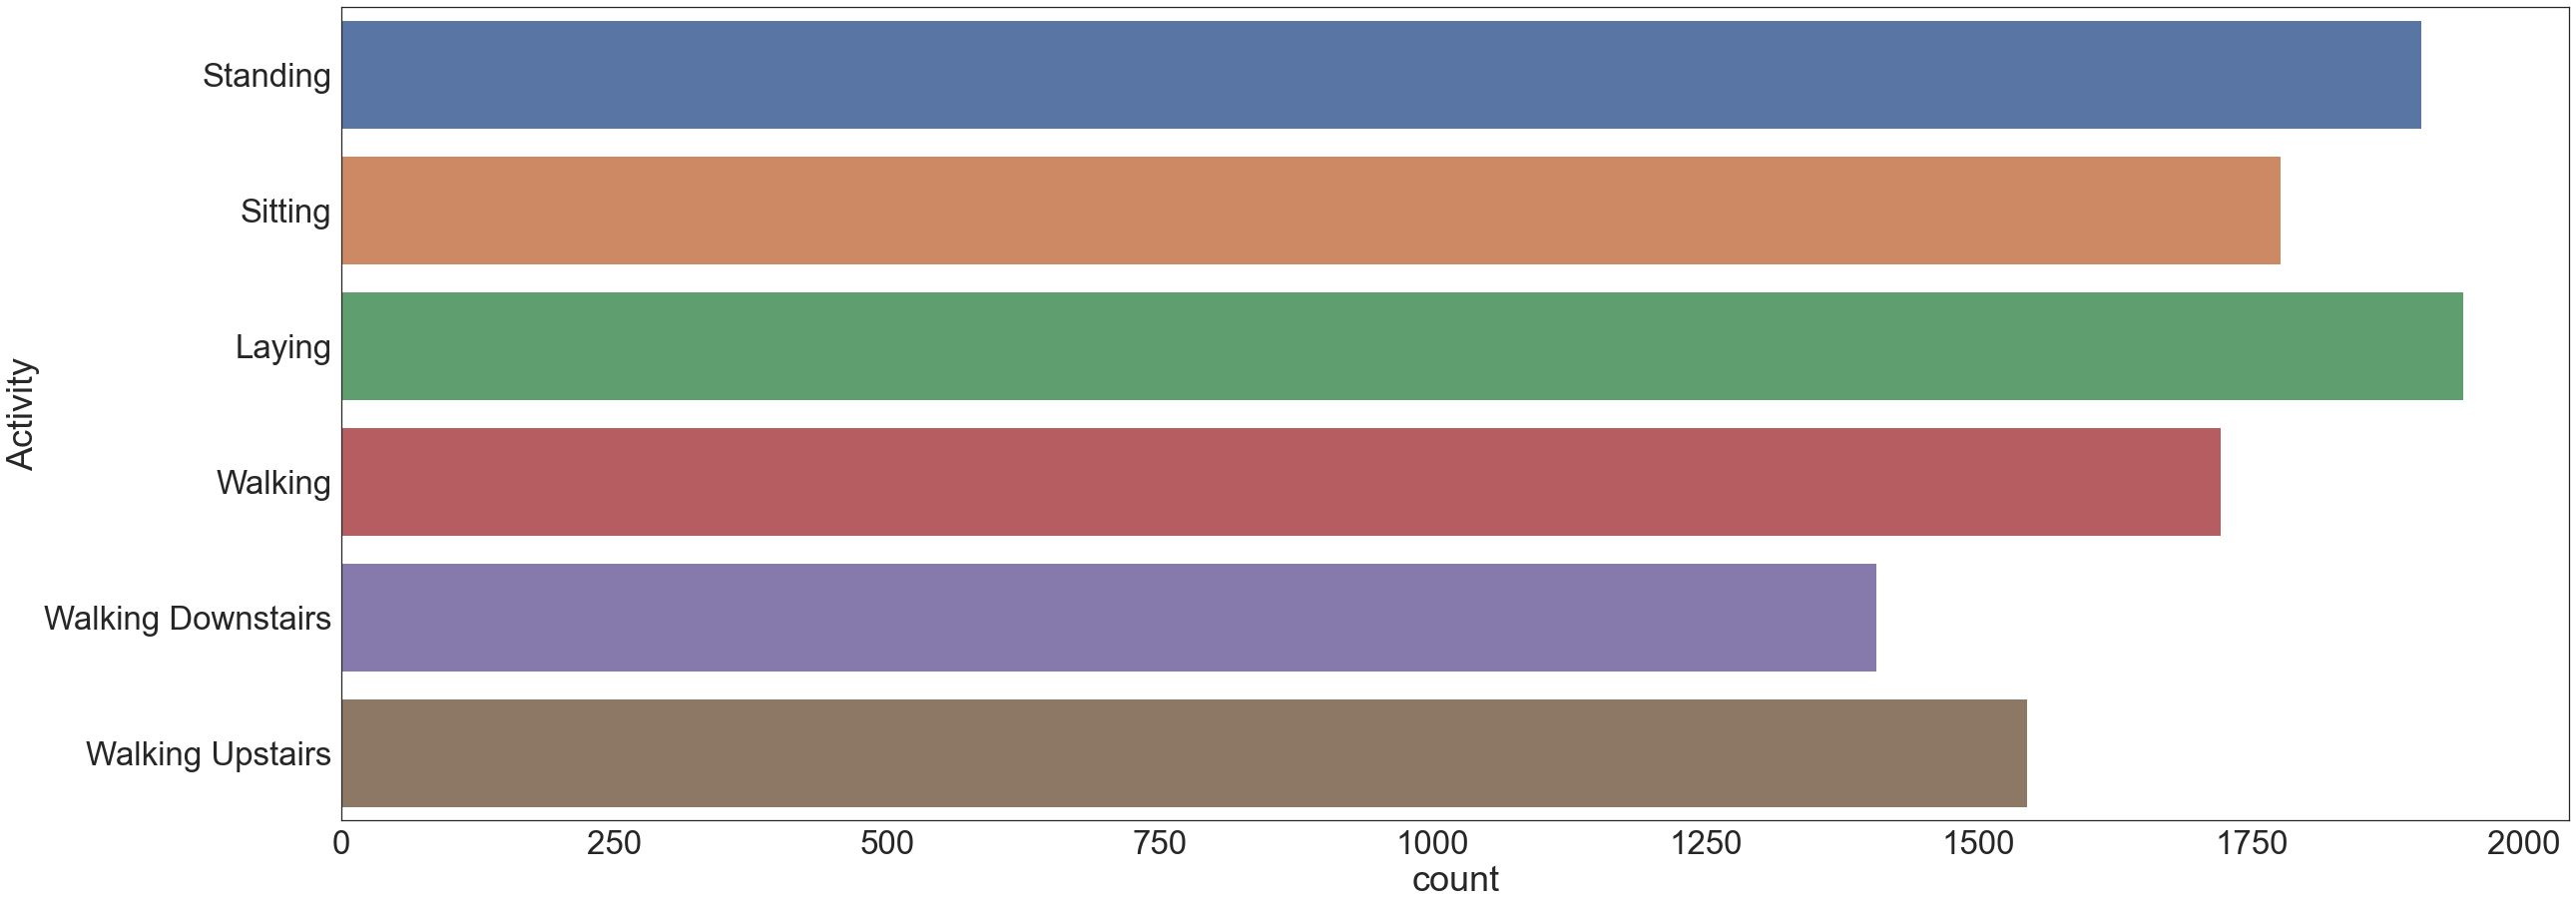

In [5]:
sns.set(style="white", font_scale = 3)
f, ax = plt.subplots(figsize=(40, 15))
sns.countplot(data=y, y="Activity")
plt.savefig("graph/activity count.png")

In [8]:
with open('data/2012/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]

In [9]:
X_train = pd.read_csv("data/2012/train/X_train.txt", delim_whitespace=True, header=None)
X_train.columns=features
X_test = pd.read_csv("data/2012/test/X_test.txt", delim_whitespace=True, header=None)
X_test.columns=features
df=pd.concat([X_test, X_train])

In [8]:
df["Activity"]=y

In [9]:
df.to_csv("EDA.csv")

In [10]:
warnings.filterwarnings('ignore')

<Figure size 2880x1080 with 0 Axes>

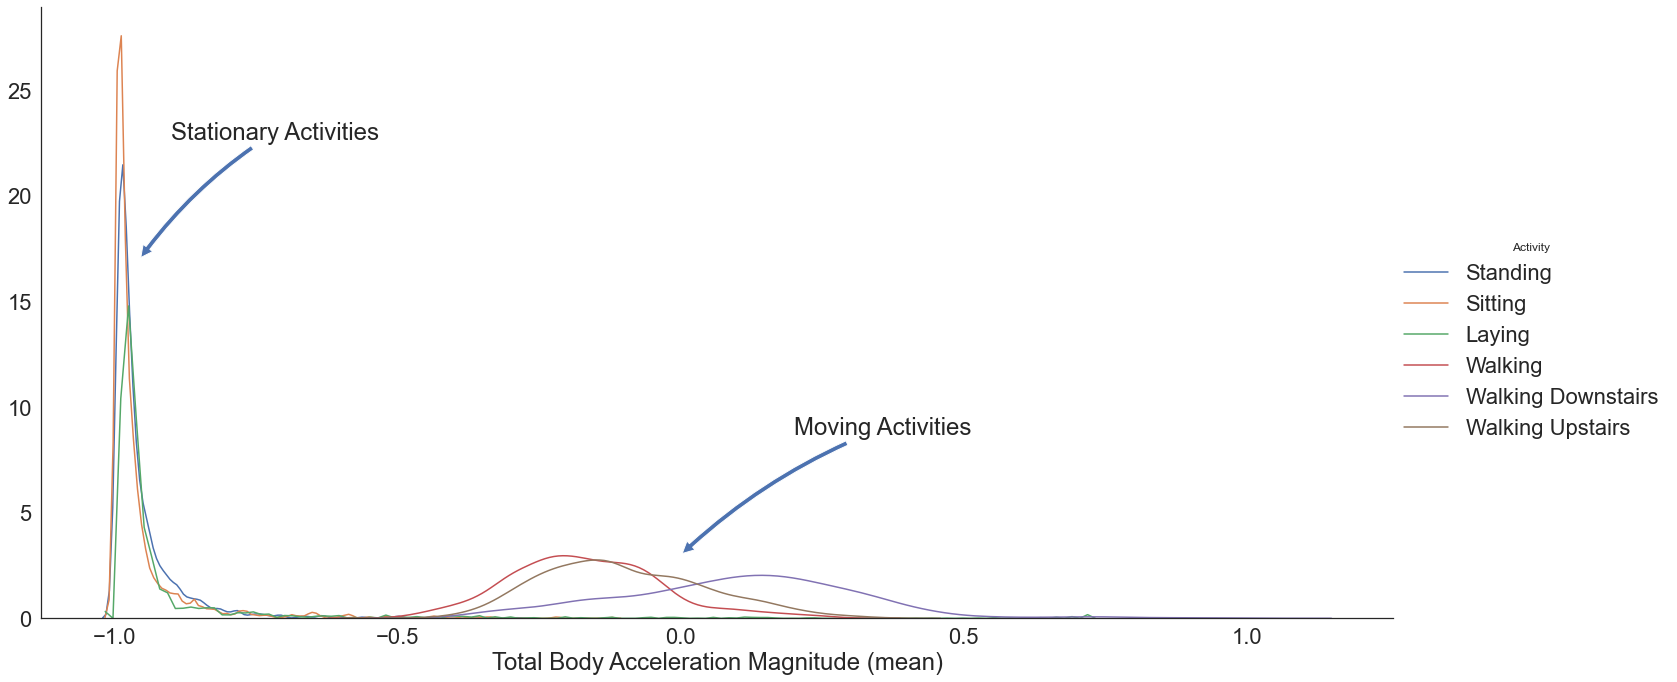

In [33]:
sns.set(style="white", font_scale = 2)
plt.figure(figsize=(40, 15))
facetgrid = sns.FacetGrid(df, hue='Activity', size=10,aspect=2)
facetgrid.map(sns.distplot,'tBodyAccMag-mean()', hist=False).add_legend()
plt.annotate("Stationary Activities", xy=(-0.956,17), xytext=(-0.9, 23),
            va='center', ha='left',
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))

plt.annotate("Moving Activities", xy=(0,3), xytext=(0.2, 9),
            va='center', ha='left',
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))
plt.xlabel("Total Body Acceleration Magnitude (mean)")
plt.savefig("graph/Total Body Acceleration Magnitude.png")
plt.show()


## Data Pipeline

In [11]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    # load all train
    X_train, y_train = load_dataset_group('train', prefix)
    print(X_train.shape, y_train.shape)
    # load all test
    X_test, y_test = load_dataset_group('test', prefix)
    print(X_test.shape, y_test.shape)
    # zero-offset class values
    y_train = y_train - 1
    y_test = y_test - 1
    # one hot encode y
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    return X_train, y_train, X_test, y_test

In [38]:
X_train, y_train, X_test, y_test = load_dataset(prefix="data/2012/")

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [12]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

In [13]:
INPUT_FOLDER_TRAIN = 'data/2012/train/Inertial Signals/'
INPUT_FOLDER_TEST = 'data/2012/test/Inertial Signals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))


LABELFILE_TRAIN = 'data/2012/train/y_train.txt'
LABELFILE_TEST = 'data/2012/test/y_test.txt'
train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

## Data Visualisation

In [14]:
N = 128
f_s = 50
t_n = 2.56
T = t_n / N
sample_rate = 1 / f_s
denominator = 10
signal_no = 55 #observation
signals = train_signals[signal_no, :, :]
signal = signals[:, 3]
label = train_labels[signal_no]
activity_name = activities_description[label]

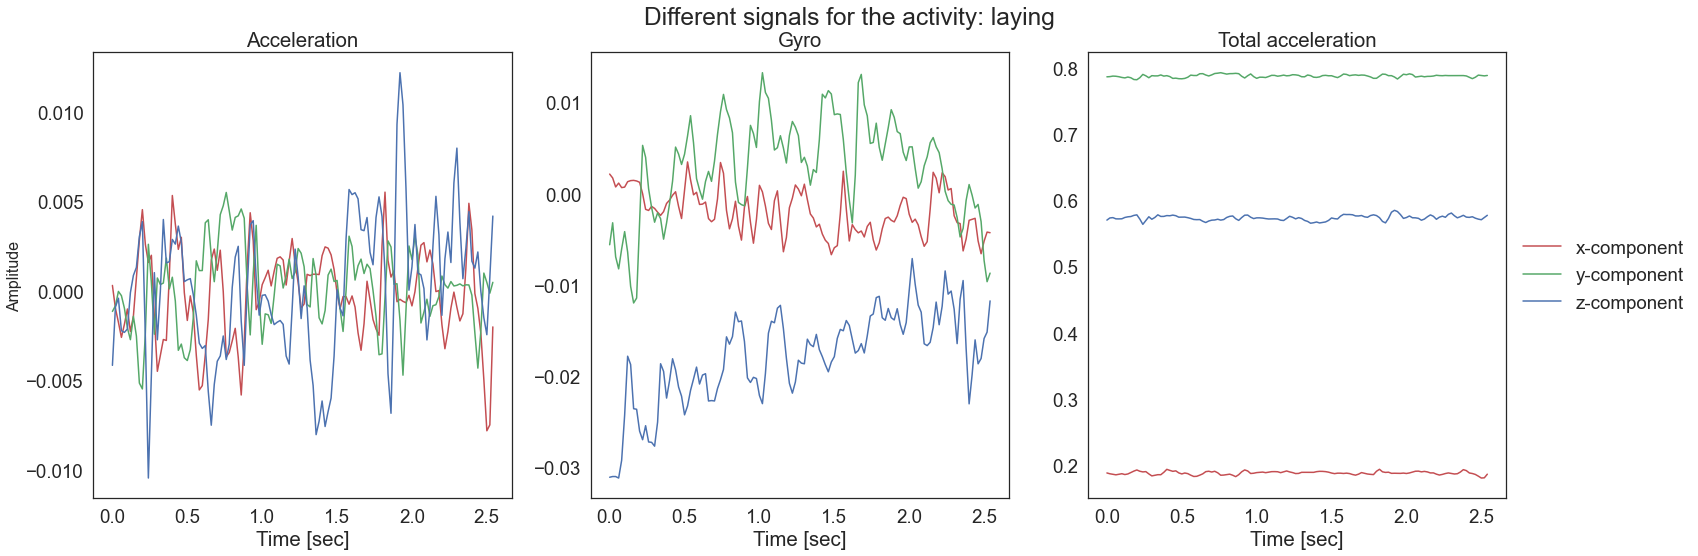

In [15]:
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [sample_rate * kk for kk in range(0,len(y_values))]
    return x_values, y_values

labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"
 
xlabel = 'Time [sec]'
ylabel = 'Amplitude'
axtitles = ['Acceleration', 'Gyro', 'Total acceleration']
           

sns.set(style="white", font_scale = 1.7)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,8))

 
for comp_no in range(0,9):
        col_no = comp_no // 3
        plot_no = comp_no % 3
        color = colors[plot_no]
        label = labels[plot_no]
 
        axtitle  = axtitles[col_no]
 
        ax = axes[col_no]
        ax.set_title(axtitle)
        ax.set_xlabel(xlabel)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)
 
        signal_component = signals[:, comp_no]
        x_values, y_values = get_values(signal_component, T, N, f_s)
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)  
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle(suptitle.format(activity_name))    
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
#plt.savefig("graph/Laying Signal.png")
plt.show()

In [16]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import matplotlib as mpl

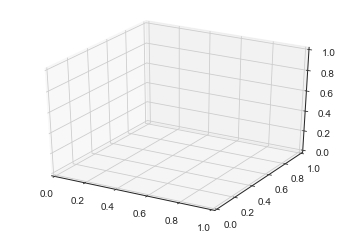

In [20]:
fig = plt.figure()
ax = plt.axes(projection="3d")
plt.show()

In [28]:
train_signals.shape

(7352, 128, 9)

##### Standing ***************************************************************

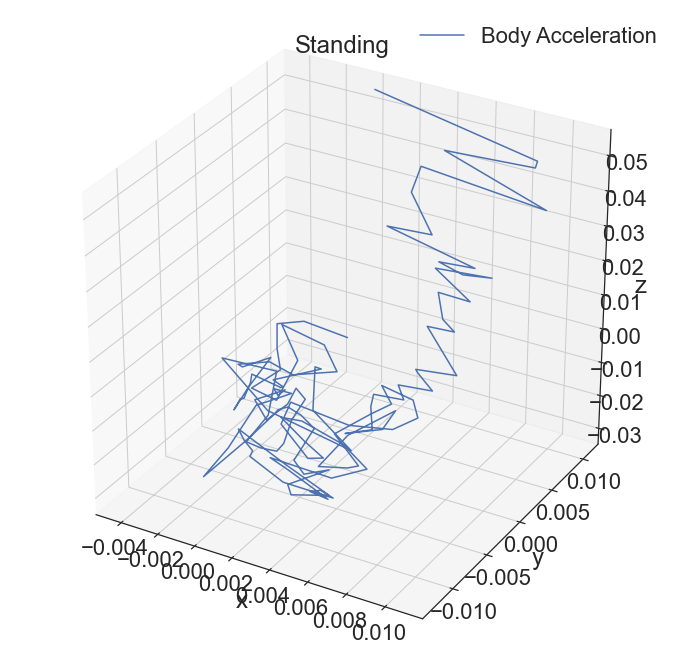

In [92]:
sns.set(style="white", font_scale = 2)
obs=train_signals[0, :, :3]
#mpl.rcParams["legend.fontsize"] = 10
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection="3d")
z = obs[:, 2]
x = obs[:, 0]
y = obs[:, 1]
ax.plot(x, y, z, label="Body Acceleration")
ax.legend()
plt.title("Standing")
plt.xlabel("x")
plt.ylabel("y")
ax.set_zlabel("z")
plt.savefig("graph/3D Standing")
plt.show()

In [55]:
activities_description[train_labels[66]]

'laying'

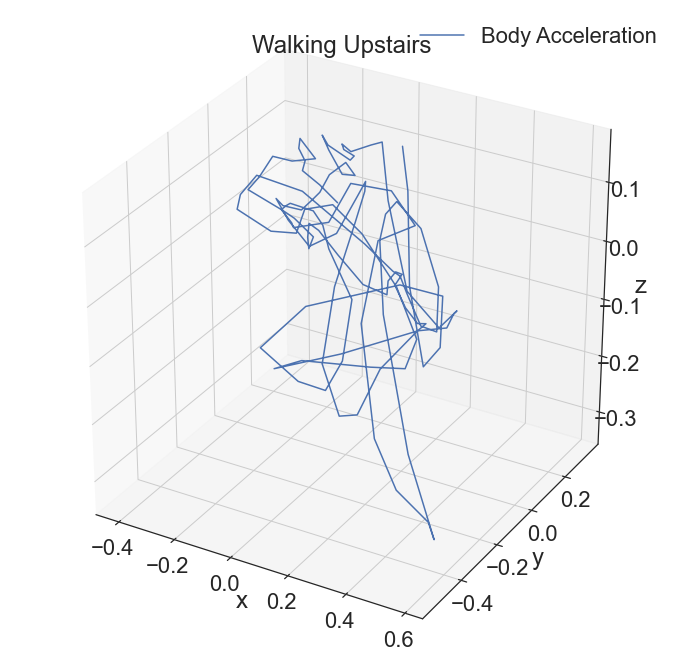

In [30]:
sns.set(style="white", font_scale = 2)
obs=train_signals[666, :, :3]
#mpl.rcParams["legend.fontsize"] = 10
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection="3d")
z = obs[:, 2]
x = obs[:, 0]
y = obs[:, 1]
ax.plot(x, y, z, label="Body Acceleration")
ax.legend()
plt.title("Walking Upstairs")
plt.xlabel("x")
plt.ylabel("y")
ax.set_zlabel("z")

plt.show()

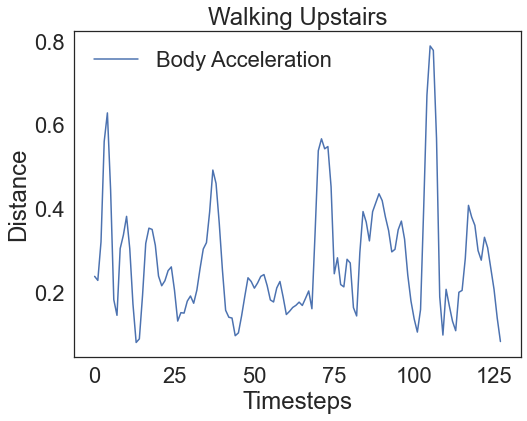

In [31]:
sns.set(style="white", font_scale = 2)
fig = plt.figure(figsize=(8,6))
plt.plot((x**2+y**2+z**2)**0.5, label="Body Acceleration") #Standing
plt.legend()
plt.title("Walking Upstairs")
plt.xlabel("Timesteps")
plt.ylabel("Distance")
plt.savefig("graph/Difference Upstairs")
plt.show()

##### Walking Downstairs

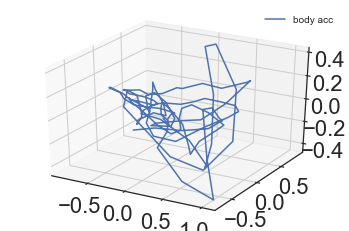

In [38]:
obs=train_signals[818, :, :3]
mpl.rcParams["legend.fontsize"] = 10
fig = plt.figure()
ax = fig.gca(projection="3d")
z = obs[:, 2]
x = obs[:, 0]
y = obs[:, 1]
ax.plot(x, y, z, label="body acc")
ax.legend()
plt.show()

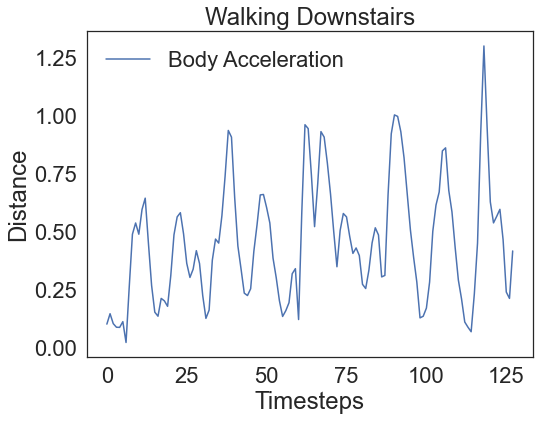

In [39]:
sns.set(style="white", font_scale = 2)
fig = plt.figure(figsize=(8,6))
plt.plot((x**2+y**2+z**2)**0.5, label="Body Acceleration") #Standing
plt.legend()
plt.title("Walking Downstairs")
plt.xlabel("Timesteps")
plt.ylabel("Distance")
plt.savefig("graph/Difference Downstairs")
plt.show()

In [37]:
activities_description[train_labels[818]]

'walking downstairs'

##### Walking

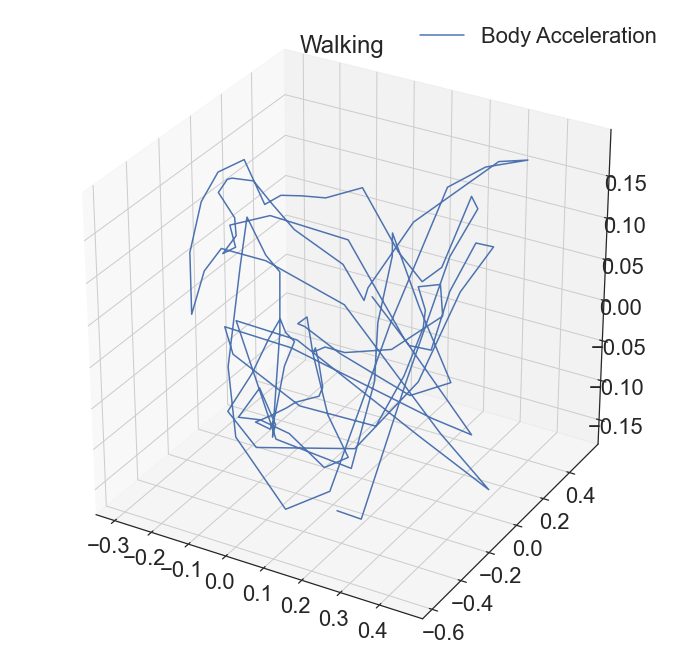

In [105]:
sns.set(style="white", font_scale = 2)
obs=train_signals[777, :, :3]
#mpl.rcParams["legend.fontsize"] = 10
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection="3d")
z = obs[:, 2]
x = obs[:, 0]
y = obs[:, 1]
ax.plot(x, y, z, label="Body Acceleration")
ax.legend()
plt.title("Walking")
#plt.savefig("graph/3D Walking")
plt.show()

##### Laying

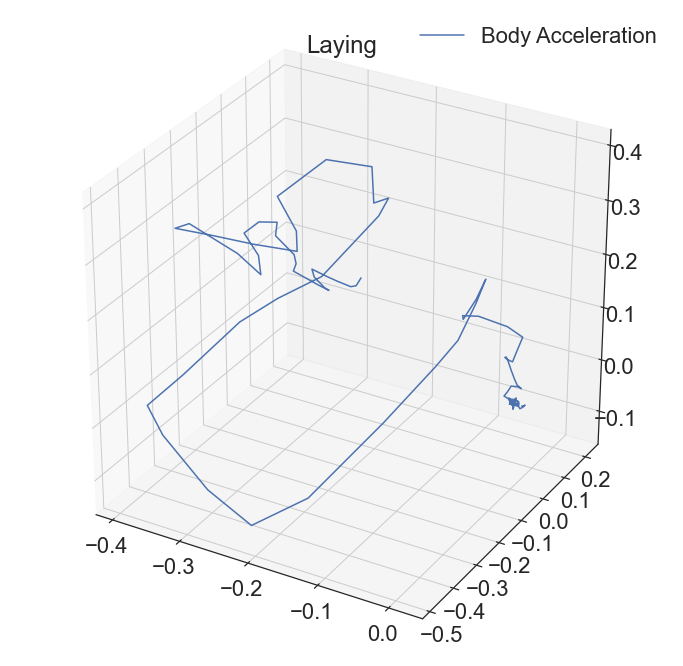

In [104]:
sns.set(style="white", font_scale = 2)
obs=train_signals[66, :, :3]
#mpl.rcParams["legend.fontsize"] = 10
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection="3d")
z = obs[:, 2]
x = obs[:, 0]
y = obs[:, 1]
ax.plot(x, y, z, label="Body Acceleration")
ax.legend()
plt.title("Laying")
#plt.savefig("graph/3D Laying")
plt.show()

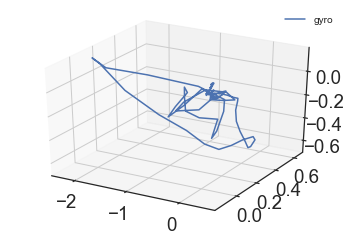

In [57]:
obs=train_signals[66, :, 3:6]
mpl.rcParams["legend.fontsize"] = 10
fig = plt.figure()
ax = fig.gca(projection="3d")
z = obs[:, 2]
x = obs[:, 0]
y = obs[:, 1]
ax.plot(x, y, z, label="gyro")
ax.legend()
plt.show()

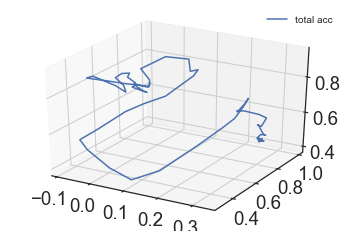

In [58]:
obs=train_signals[66, :, 6:]
mpl.rcParams["legend.fontsize"] = 10
fig = plt.figure()
ax = fig.gca(projection="3d")
z = obs[:, 2]
x = obs[:, 0]
y = obs[:, 1]
ax.plot(x, y, z, label="total acc")
ax.legend()
plt.show()

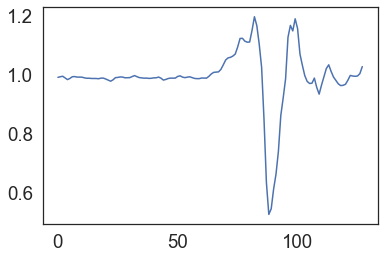

In [62]:
plt.plot((x**2+y**2+z**2)**0.5) #Laying

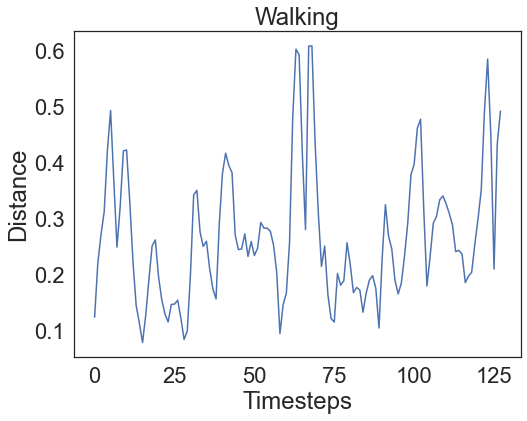

In [103]:
sns.set(style="white", font_scale = 2)
fig = plt.figure(figsize=(8,6))
plt.plot((x**2+y**2+z**2)**0.5, label="Body Acceleration") # Walking
plt.title("Walking")
plt.xlabel("Timesteps")
plt.ylabel("Distance")
plt.savefig("graph/Walking Difference")
plt.show()

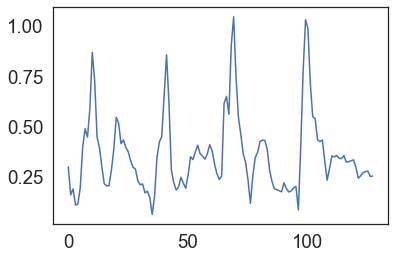

In [66]:
plt.plot((x**2+y**2+z**2)**0.5) #Walking Downstairs

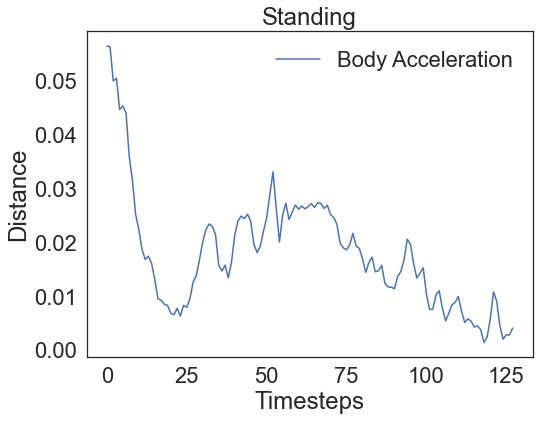

In [100]:
sns.set(style="white", font_scale = 2)
fig = plt.figure(figsize=(8,6))
plt.plot((x**2+y**2+z**2)**0.5, label="Body Acceleration") #Standing
plt.legend()
plt.title("Standing")
plt.xlabel("Timesteps")
plt.ylabel("Distance")
plt.savefig("graph/Standing Difference")
plt.show()

In [ ]:

obs=train_signals[777, :, :3]
#mpl.rcParams["legend.fontsize"] = 10

ax = fig.gca(projection="3d")
z = obs[:, 2]
x = obs[:, 0]
y = obs[:, 1]
ax.plot(x, y, z, )

ax.set_zlabel("z")
